# Update your repository with new stuff
#### Note this is technically not good practice here, but we'll worry about that later

- Open git bash to your learning python folder

- git checkout -b session2

- git remote add upstream https://github.com/tne-lab/learning-python

- git fetch upstream

- git merge upstream/master --strategy-option theirs

### Open Jupyter Notebook and open Session_2.ipynb


# Today we will look at events first


In [1]:
import os
import OpenEphys

cwd = os.getcwd() # Gets your current working directory

pathToEvents = cwd + '\\data\\Sample_Data\\all_channels.events' # All events are stored here
 
allEvents = OpenEphys.load(pathToEvents)
print('events loaded in!')

pathToData = cwd + '\\data\\Sample_Data\\100_CH1.continuous' # You can change this to look at other channels!
 
data = OpenEphys.load(pathToData)
print('data loaded in!')

loading events...
events loaded in!
Loading continuous data...
data loaded in!


In [2]:
# What is events?
print(type(allEvents))

# Lets look at what is stored in here.
for key in allEvents.keys():
    print(key)

<class 'dict'>
header
channel
timestamps
eventType
nodeId
eventId
recordingNumber
sampleNum


## Build a class to store event data

In [3]:
import numpy as np

class Events:
    # Put code here (use Con class below as a reference!)
    def __init__(self, data, tsStart):
        self.eventId = data['eventId'] # Event id holds info about the event. TTL event: 1 = On, 0 = Off
        self.nodeId = data['nodeId'] # What node (Plugin) did this event come from?
        self.eventType = data['eventType']
        self.channel = data['channel']

        self.ts = []
        for t in data['timestamps']:
            self.ts.append(t - tsStart) # Zero out the timestamp to correspond with continuous data

class Con:
    def __init__(self, data):
        self.data = data['data'] # Volatage data
        self.fs = float(data['header']['sampleRate']) # Sample Rate
        self.interpTs(data['timestamps']) # Interpolate timestamps for all data points (Only has 1 time stamp for each buffer of 1024 data points)

    def interpTs(self, ts):
        tsStart = ts[0]
        tsEnd = ts[len(ts)-1]
        self.ts = np.linspace(tsStart, tsEnd, len(ts) * 1024) # Creates the array of timestamps
        i = 0
        for t in self.ts:
            self.ts[i] = t - tsStart # Zero out the timestamps, just makes it look better when graphing/explaining
            i = i + 1
        self.tsStart = tsStart # Send the ts start to event data
        
con = Con(data)
events = Events(allEvents, con.tsStart)
print('Classes finished!')

### And we can plot these events on top of our ephys data

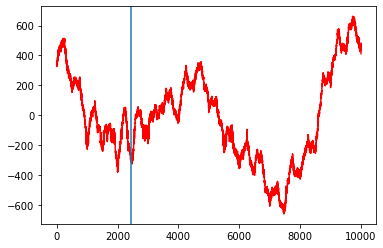

In [5]:
import matplotlib.pyplot as plt
plt.plot(con.data[:10000], 'r')
plt.axvline(events.ts[0])
plt.show()

### Let's check out the settings.xml file in Sample_Data

In [6]:
pathToPhaseCalc = cwd + '\\data\\Sample_Data\\104_CH1.continuous'
rawPhase = OpenEphys.load(pathToPhaseCalc)

conPhase = Con(rawPhase)
print('Phase calc loaded in')

Loading continuous data...
Phase calc loaded in


In [49]:
from scipy import signal
def myBandpass(lowcut, highcut, fs, data):
    nyq = 0.5 * fs
    low = lowcut /nyq
    high = highcut /nyq
    band = [low, high]
    order = 2
    b, a = signal.butter(order, band, btype='bandpass')
    
    filteredData = signal.lfilter(b, a, data)
    return filteredData

filteredData = myBandpass(4, 8, con.fs, con.data[:10000])

### So what is phase?
https://en.wikipedia.org/wiki/Phase_(waves)#/media/File:Oscillating_sine_wave.gif

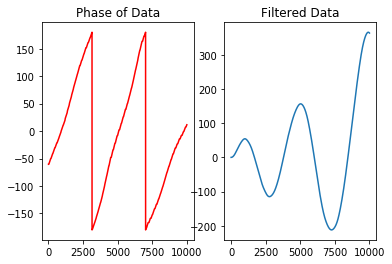

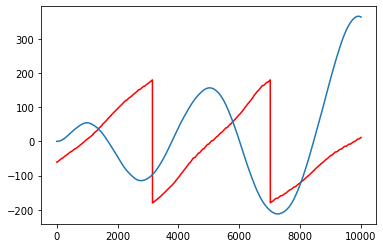

In [50]:
fig, ax = plt.subplots(1,2)

ax[0].plot(conPhase.data[:10000], 'r')
ax[0].set_title('Phase of Data')

ax[1].plot(filteredData)
ax[1].set_title('Filtered Data')

fig, ax = plt.subplots(1,1)
ax.plot(conPhase.data[:10000], 'r')
ax.plot(filteredData)


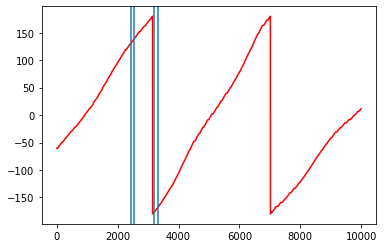

In [42]:
plt.plot(conPhase.data[:10000], 'r')
for ts in events.ts[0:4]:
    plt.axvline(ts)
plt.show()

### Challenge 1

Determine the average lag time between the pulse and the stim!

In [51]:
# Code here

### Challenge 2

Determine the average phase at pulse and stim times and plot a rose plot of the data

In [ ]:
# Rose plot code here (I used google)
def Rose(...):
    ...

In [ ]:
# Find average phases and plot them